In [24]:
import numpy as np
from collections import deque
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
from scipy.signal import savgol_filter
from math import floor
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd

from BOCD import bocd_meanNstd, NormalUnKnownMeanPrecision
def HotellingT2(window):
    '''
    Find indexes of anomaly using Hotelling T-square method
    calculate T2 score for each point & compare with calculated Upper-confidence-level.
    if exceed, anomaly

    :param window: data list
    :return: indexes of anomaly
    '''
    alpha = 0.2  #FIXME : must be larger value
    p = 1
    m = len(window)
    q = 2 * (m - 1) ** 2 / (3 * m - 4)

    UCL = (m - 1) ** 2 * stats.beta.isf(alpha, p / 2, (q - p - 1) / 2) / m

    mean = np.mean(window)
    V = np.array([])
    T2_list = []

    for ind in range(m - 1):
        V = np.append(V, window[ind + 1] - window[ind])

    S = np.array([0.5 * V.transpose() @ V / (m - 1)])

    for item in window:
        delta = np.array(item) - np.array(mean)
        T2 = delta * np.linalg.inv(np.array([S])) * delta
        T2_list.append(T2)

    anomaly = []
    for ind, value in enumerate(T2_list):
        if value > UCL:
            anomaly.append(ind)

    return anomaly


class Operator(object):    
    def __init__(self, Nw=15, Nomin=3, Nomax=20):
        '''
        :param Nw: window size for outlier
        :param Nomin: min window size for waiting Mounter-FeedBack (MFB) reflection
        :param Nomax: max window size for waiting Mounter-FeedBack (MFB) reflection
        '''
        
        self.LastCPD = 0  # index
        self.LastOP = 0  # index
        self.LastSubOP = 0  # index
        
        self.IsCPD = False
        
        # status : two status considered i.e. 'noFBapplied' & 'FBapplied'
        self.status = 'noFBapplied'

        # window size
        self.Nw = Nw  # mentioned
        self.Nomin = Nomin  # mentioned
        self.Nomax = Nomax  # mentioned
        self.Nstd = Nw  # mentioned

        # data list
        
        self.data = []  # data list (FB applied list : collected data list if online production)

        # data window
        self.window = deque([], maxlen=self.Nw)  # Raw data list for calculating offset & for smoothing (Nw data)
        self.window_for_compare = deque([], maxlen=self.Nw)  # Smoothed data list to compare threshold & current state

        # Target & Threshold
        self.Target = 0
        self.offset_threshold = None

        # Operation
        self.sub_operation = False  # where or not already applied sub-operation, as sub-op applied only once right after CPD

        # waiting step for reflection
        self.wait_num = 0  # counting number for monitoring Mounter-FeedBack delay
        self.abrupt_num = 0  # number counting low p-value point for Abrupt CPD
        self.p = 0.05  # respective lower & upper p-value for Abrupt CPD
        self.estimator = None  # Gaussian KDE for Abrupt CPD => p-value calculated based on the Gaussian KDE regressed distribution

    def clear(self):
        self.LastCPD = 0  # index
        self.LastOP = 0  # index
        self.LastSubOP = 0  # index
        
        self.IsCPD = False
        
        # status : two status considered i.e. 'noFBapplied' & 'FBapplied'
        self.status = 'noFBapplied'

        # data list
        self.data = []  # total data list (FB applied list : collected data list if online production)

        # data window
        self.window = deque([], maxlen=self.Nw)  # Raw data list for calculating offset & for smoothing (Nw data)
        self.window_for_compare = deque([], maxlen=self.Nw)  # Smoothed data list to compare threshold & current state

        # Target & Threshold
        self.Target = 0
        self.offset_threshold = None

        # Operation
        self.sub_operation = False  # where or not already applied sub-operation, as sub-op applied only once right after CPD

        # waiting step for reflection
        self.wait_num = 0  # counting number for monitoring Mounter-FeedBack delay
        self.abrupt_num = 0  # number counting low p-value point for Abrupt CPD
        self.estimator = None  # Gaussian KDE for Abrupt CPD => p-value calculated based on the Gaussian KDE regressed distribution

        return None
        
    def _run_CPD(self):
        '''
        Check if change has occurred in the latest (No + Nw) data
        :return: True/False, sequence point of CP
        '''
        # BOCD 가동
        TimeSequence = self.Nw + len(self.data) - self.LastOP  # window size for detecting change-point

        std = np.std(np.array(self.data[-TimeSequence:][:self.Nw]))  # Std calculation for BOCPD FIXME (:self.Nw)

        mu0 = 0  # Prior on Gaussian mean. (A parameter of normal-gamma prior distribution)
        gamma0 = 1  # (A parameter of normal-gamma prior distribution)
        alpha0 = 1  # (A parameter of normal-gamma prior distribution)
        beta0 = alpha0 * std ** 2  # "sqrt(beta/alpha) = std" (A parameter of normal-gamma prior distribution)

        hazard = 1 / 50.0  # Hazard survival function assumes probability to be a CP for each data point. #FIXME (1/20.0 ??)
        message = np.array([1])  # Iterative message calculated using previously collected data.

        Data_list = []
        RL_dist_list = []
        Temp_RL_dist = np.zeros((TimeSequence, TimeSequence))

        model = NormalUnKnownMeanPrecision(mu0, gamma0, alpha0, beta0)  # Data assumed be to a normal distribution.
        # Case : Both of mean and std unknown
        # BOCPD class called.

        RL = []  # Run-Length distribution initial list
        Start = []  # Estimated Change-Point starting point
        cp_list = [0]  # Detected Change-Point sequence saved list

        for ind, cont in enumerate(range(TimeSequence)):
            Data_list.append(self.data[-TimeSequence + ind])
            RL_dist, new_joint = bocd_meanNstd(data_list=Data_list, model=model,
                                               hazard=hazard, Message=message)

            message = new_joint  # each point sequential likelihood, or numerator of RL posterior distribution.
            RL_dist_list.append(RL_dist)
            Temp_RL_dist[ind, :ind + 1] = RL_dist[1:]  # RL distribution temporary saved as a element of a list

            RL.append(np.argmax(
                Temp_RL_dist[ind]))  # The highest probability corresponding sequence of RL posterior distribution
            Start.append((ind, ind - RL[-1]))

            if ind >= 1:
                if Start[-1][1] != Start[-2][1]:
                    if max(cp_list) > ind - RL[-1]:
                        cp_list = cp_list[:-1]  # Remove the lastly added Change-Point
                    else:
                        cp_list.append(ind - RL[-1])  # Change-point Detected and append into the list

        if not cp_list:  # If no FeedBack candidate found
            return False, None
        elif cp_list[-1] < self.Nw:  # Exclude a CP ahead of FeedBack operation applied sequence
            return False, None
        else:
            for cp in cp_list[1:]:  # Exclude initial point (the point '0')
                self.LastCPD = len(self.data) - TimeSequence + cp_list[-1]
            self.IsCPD = True
            return True, cp_list[-1]

    def _is_within_threshold(self):
        '''
        Check if the smoothed data is inside the threshold
        :return: True/ False ('True' if data lies within threshold )
        '''
        is_withinThreshold = False

        # Outlier : Last Nw smoothed data must be the same sign
        '''
        check = 0
        for smoothed in self.window_for_compare:
            check += np.sign(smoothed)

        if np.abs(check) != self.Nw:
            is_withinThreshold = True  
        '''
        check = np.sign(self.window_for_compare[0])
        for smoothed in self.window_for_compare:
            if(check != np.sign(smoothed)):
                is_withinThreshold = True; break; #FIXME (Non-same-sign which is anomaly ??)

        # Outlier : Last Nw smoothed data must be out of threshold.
        for smoothed in self.window_for_compare:
            if np.abs(smoothed - self.Target) <= self.offset_threshold:
                is_withinThreshold = True

        return is_withinThreshold

    def _do_operation(self):
        '''
        Apply operation & Set operation delay
        OUTPUT : operation
        '''
        self.sub_operation = False

        # Exclude anomaly before calculating offset by using Hotelling's T2
        windowForAnomaly = self.window
        anomaly = HotellingT2(windowForAnomaly)
        for delete_ind, anomaly_ind in enumerate(anomaly):
            del windowForAnomaly[anomaly_ind - delete_ind] # windowForAnomaly : Anomaly excluded window 

        # Calculate offset & operation
        offset = np.mean(windowForAnomaly)
        
        # Append operation index
        self.LastOP = len(self.data)
        
        return self.Target - offset


    def _do_sub_operation(self):
        '''
        Apply sub-operation & Set sub-operation delay
        OUTPUT : operation
        '''
        self.sub_operation = True  # number of sub operations

        # Exclude anomaly before calculating offset by using Hotelling's T2
        windowForAnomaly = self.data[max(self.LastCPD, self.LastOP):]
        anomaly = HotellingT2(windowForAnomaly)
        for delete_ind, anomaly_ind in enumerate(anomaly):
            del windowForAnomaly[anomaly_ind - delete_ind] # windowForAnomaly : Anomaly excluded window 

        # Calculate offset & operation
        offset = np.mean(windowForAnomaly)
        
        # Append sub-operation index
        self.LastSubOP = len(self.data)
        
        self.clear()
        
        return self.Target - offset


    def step(self, feature):
        '''
        MFB Loop
        :param feature: offset data
        :return: None
        '''
        self.IsCPD = False
        
        # START
        if self.status == 'noFBapplied':
            self._put_feature(feature)

            # Enough data ?
            if len(self.data) - self.LastCPD < self.Nw:
                return 0, None

            # Check if lies within calculated threshold. If not, do operation.
            if self._is_within_threshold():
                if len(self.data) == self.Nw:
                    self.clear()
                    return 0, 'IN'
                # If state is on target & stable, do one sseub-operation.
                if not self.sub_operation: # "False" if no sub-operation from last CPD point. (As only one sub-op applied for one ADF-test steady-state)
                    check_point = max(self.LastCPD, self.LastOP) #'op_list':not considered delay operation index list, 'CPD_list': BOCPD found CPD index list
                    if (len(self.data) - check_point) >= self.Nw:  # There must be enough data after Op. or CPD.
                        if adfuller(self.data[check_point:])[1] < 1e-6:  # Stable?
                            return self._do_sub_operation(), 'SUB'
#                         if (len(self.data) - check_point) <= 2*self.Nw:
#                             self.clear()
#                             return 0, 'IN'
                return 0, None
            else:
                self.estimator = stats.gaussian_kde(self.window)  # Set Gaussian KDE for Abrupt CPD.   # FIXME : minimum of delay given, then calculate the estimator
                self.status = 'FBapplied'
                return self._do_operation(), 'MAIN' # SG-filter smoothing is not consider anomaly # FIXME
                
        # Waiting for FB to be applied.
        if self.status == 'FBapplied':
            self._put_feature(feature)
            self.wait_num += 1

            # Abrupt CPD : repeating low p-value point or waiting enough fires BOCD
            if self.estimator.integrate_box_1d(-np.Inf, feature) < self.p or \
                    self.estimator.integrate_box_1d(-np.Inf, feature) > 1 - self.p:
                self.abrupt_num += 1

            if self.wait_num >= self.Nomax:
                self._run_CPD()  # CPD fired
                self.wait_num = 0  # Reset self.wait_num
                self.abrupt_num = 0  # Reset self.abrupt_num
                self.status = 'noFBapplied'  # Reset self.status
                return 0, None

            elif self.abrupt_num >= self.Nomin:
                self._run_CPD()  # CPD fired
                self.wait_num = 0  # Reset self.wait_num
                self.abrupt_num = 0  # Reset self.abrupt_num
                self.status = 'noFBapplied'  # Reset self.status
                return 0, None

            else:
                return 0, None
            

        
    def _put_feature(self, feature):
        '''
        Get offset data
        :param feature: offset data
        :return: None
        '''
        # Append feature to data lists
        self.data.append(feature)  # Collected total data
        self.window.append(feature)  # Nw corresponding window size

        # Initialize the threshold
        if len(self.data) == self.Nstd:   # FIXME use once at the initial stage (put outside of the state stage)
            self.offset_threshold = 0.5 * np.std(self.data)

        # Data smoothing
        if len(self.data) >= self.Nw:
            savgol_result = savgol_filter(self.data[-self.Nw:], 2*floor((self.Nw-1)/2)+1, 3)
            self.window_for_compare = savgol_result  ## compare threshold with sg-filter regressed line
                    
        # Reset the threshold
        if (len(self.data) - self.LastCPD) % self.Nstd == 0:
            buffer = self.data[-self.Nstd:]
            STD = np.std(buffer)
            if 0.7 * self.offset_threshold > STD or self.offset_threshold < 0.7 * STD:
                self.offset_threshold = 0.5 * STD

In [91]:
class MounterFeedback(object):
    def __init__(self, MaxOpNum = 20, Nw = 15):
        self.MaxOpNum = MaxOpNum
        self.Nw = Nw
        
        self.Operator_DF = None
        self.Operation_DF = None
        self.CPD_DF = None
        
        self.Component_Info_List = []
        
        self.DataReader = DataReader(Nw=Nw)
        
        self.state = 'noInitialShifting'
        self.step_num = 0
        
        self.json_data = None
        
        self.CoordinateMode = None
        
    def Ready(self, json_data):
        '''
        Initialize MFB algorithm & Ready for feedback
        :param json_data
        :return: None
        '''
        self.DataReader.Ready(json_data)
        self.Component_Info_List = self.DataReader.Component_Info_List
        
        # Init operator_df & operation_df
        
        operator_dict = {}
        current_state_dict = {}
        previous_state_dict = {}
        operation_dict = {}
        cpd_dict = {}
        
        for (BLOCK_NO,REFERENCE) in self.Component_Info_List:        
            operator_pair = {}
            current_state_pair = {}
            previous_state_pair = {}
            operation_pair = {}
            cpd_pair = {}
            for AXIS in ['LENGTH','WIDTH']:
                operator_pair[AXIS] = Operator(Nw=15, Nomin=3, Nomax=15)
                current_state_pair[AXIS] = 'OFF'
                previous_state_pair[AXIS] = 'OFF'
                operation_pair[AXIS] = (0, None)
                cpd_pair[AXIS] = -1
                
            operator_dict[(BLOCK_NO,REFERENCE)] = operator_pair
            current_state_dict[(BLOCK_NO,REFERENCE)] = current_state_pair
            previous_state_dict[(BLOCK_NO,REFERENCE)] = previous_state_pair
            operation_dict[(BLOCK_NO,REFERENCE)] = operation_pair
            cpd_dict[(BLOCK_NO,REFERENCE)] = cpd_pair
            
        self.Operator_DF = pd.DataFrame(operator_dict).T
        self.Operation_DF = pd.DataFrame(operation_dict).T
        self.CPD_DF = pd.DataFrame(cpd_dict).T
        
        
        
    def ReturnFeedbackInfo(self):
        FEEDBACK_INFO = {"FeedbackType": "PLACEDLOCATIONOFFSET",
                         "SeqID": self.json_data["ASST_SEQNO"],
                         "Time": self.json_data["END_DATE_TIME"],
                         "MachineName": self.json_data["MACHINE_NM"],
                         "LaneNo": self.json_data["LANE_NO"],
                         "Target": '1',
                         "NumList": len(self.json_data["COMPONENT"]),
                         "CPDLIST": [],
                         "OFFSETLIST": []}
        

        for (BLOCK_NO,REFERENCE) in self.Component_Info_List:
            FEEDBACK_INFO["OFFSETLIST"].append(
                {'BLOCK_NO': BLOCK_NO, 'REFERENCE': REFERENCE,
                 'AdjustX': self.Operation_DF['LENGTH'][(BLOCK_NO,REFERENCE)],
                 'AdjustY': self.Operation_DF['WIDTH'][(BLOCK_NO,REFERENCE)]})
            
            FEEDBACK_INFO["CPDLIST"].append(
                {'BLOCK_NO': BLOCK_NO, 'REFERENCE': REFERENCE,
                 'LENGTH_CPD': self.CPD_DF['LENGTH'][(BLOCK_NO,REFERENCE)],
                 'WIDTH_CPD': self.CPD_DF['WIDTH'][(BLOCK_NO,REFERENCE)]})
                
        return FEEDBACK_INFO
        
    
    def Step(self, json_data):
        '''
        param json_data
        return: feedback information as dictionary
        '''
        self.json_data = json_data
        
        # Before Initial Shifting
        if self.state == 'noInitialShifting':
            self.step_num += 1
            self.DataReader.Step(json_data)
            
            # Initial Shifting
            if self.step_num == self.Nw:
                for AXIS in ['LENGTH','WIDTH']:
                    for (BLOCK_NO,REFERENCE) in self.Component_Info_List:
                        # Exclude anomaly before calculating offset by using Hotelling's T2
                        windowForAnomaly = self.DataReader.PullFeatures(
                                AXIS,(BLOCK_NO,REFERENCE),num=self.Nw)
                        anomaly = HotellingT2(windowForAnomaly)
                        for delete_ind, anomaly_ind in enumerate(anomaly):
                            del windowForAnomaly[anomaly_ind - delete_ind] 
                            
                        self.Operation_DF[AXIS][(BLOCK_NO,REFERENCE)] =\
                            (-np.mean(windowForAnomaly), 'INITIAL')
                
                self.state = 'InitialShiftingDone'
            return self.ReturnFeedbackInfo()
        
        # After Initial Shifting
        if self.step_num == self.Nw:
            for AXIS in ['LENGTH','WIDTH']:
                for (BLOCK_NO,REFERENCE) in self.Component_Info_List:
                    self.Operation_DF[AXIS][(BLOCK_NO,REFERENCE)] = (0, None)
            self.DataReader.ResetDataframe()
            
        if self.state == 'InitialShiftingDone': 
            self.step_num += 1
            self.DataReader.Step(json_data)

            if len(self.DataReader.Feature_DF_List) < self.Nw :
                return self.ReturnFeedbackInfo()

            for AXIS in ['LENGTH','WIDTH']:
                for (BLOCK_NO,REFERENCE) in self.Component_Info_List:
                    operation = self.Operator_DF[AXIS][(BLOCK_NO,REFERENCE)].step(
                        self.DataReader.PullFeatures(AXIS,(BLOCK_NO,REFERENCE))[0])

                    self.Operation_DF[AXIS][(BLOCK_NO,REFERENCE)] = operation

            for AXIS in ['LENGTH','WIDTH']:
                for (BLOCK_NO,REFERENCE) in self.Component_Info_List:
                    if self.Operator_DF[AXIS][(BLOCK_NO,REFERENCE)].IsCPD:
                        self.CPD_DF[AXIS][(BLOCK_NO,REFERENCE)] = self.step_num
                    else :
                        self.CPD_DF[AXIS][(BLOCK_NO,REFERENCE)] = -1
    
            return self.ReturnFeedbackInfo()


In [92]:
class DataReader(object):
    def __init__(self, Nw = 15):
        self.Nw = Nw
        self.Feature_DF_List = deque([],maxlen=Nw)
        self.Component_Info_List = []
        
    
    def Ready(self, json_data):
        '''
        Set Component Info. List
        :param json_data
        :return: None
        '''
        for ind in range(len(json_data['COMPONENT'])):
            BLOCK_NO = json_data['COMPONENT'][ind]['BLOCK_NO']
            REFERENCE = json_data['COMPONENT'][ind]['REFERENCE']
            
            self.Component_Info_List.append((BLOCK_NO,REFERENCE))
            
        return None
    
    def Step(self, json_data):
        
        feature_dict = {}
        for ind, (BLOCK_NO,REFERENCE) in enumerate(self.Component_Info_List):
            feature_pair = {}
            for AXIS in ['LENGTH','WIDTH']:
                feature_pair[AXIS] =  float(
                    json_data['COMPONENT'][ind]['INSP_TYPE_VALUE'][0]['PADOVERHANG'][AXIS])
            feature_dict[(BLOCK_NO,REFERENCE)] = feature_pair
        
        self.Feature_DF_List.append(pd.DataFrame(feature_dict).T)
        
        return None
    
    def ResetDataframe(self):
        self.Feature_DF_List = deque([],maxlen=self.Nw)
        return None
    
    def PullFeatures(self, Axis, component_info, num = 1):
        feature_list = []
        for n in range(num):
            feature_list.append(float(self.Feature_DF_List[n-num][Axis][component_info]))
            
        return feature_list
    
    def PullLastDataframe(self):
        return self.Feature_DF_List[-1]
    

In [93]:
class MounterSimulator(object):
    def __init__(self, json_data):
        self.Component_Info_List = []
        
        for ind in range(len(json_data['COMPONENT'])):
            BLOCK_NO = json_data['COMPONENT'][ind]['BLOCK_NO']
            REFERENCE = json_data['COMPONENT'][ind]['REFERENCE']
            self.Component_Info_List.append((BLOCK_NO,REFERENCE))
            
        operations = {}
        for (BLOCK_NO,REFERENCE) in self.Component_Info_List:
            pair = {}
            for AXIS in ['LENGTH','WIDTH']:
                pair[AXIS] = 0
            operations[(BLOCK_NO,REFERENCE)] = pair
            
        self.operation_buffer = pd.DataFrame(operations).T
        self.operation = copy.deepcopy(self.operation_buffer)
        self.delay =  copy.deepcopy(self.operation_buffer)
        
        self.PCB_INFO = None
        
    def PLANT(self, FEEDBACK_INFO, json_data):
        self.PCB_INFO = copy.deepcopy(json_data)
        
        for FB_AXIS, AXIS in zip(['AdjustX','AdjustY'],['LENGTH','WIDTH']):
            for component_index, component_info in enumerate(self.Component_Info_List):
                
                # Op. 명령 확인 시 처리.
                if FEEDBACK_INFO['OFFSETLIST'][component_index][FB_AXIS][0] != 0:
                    self.delay[AXIS][component_info] = round(np.random.exponential(scale=2))+1
                    self.operation_buffer[AXIS][component_info] \
                        = FEEDBACK_INFO['OFFSETLIST'][component_index][FB_AXIS][0]
                    
        # 딜레이 시뮬레이션
        for AXIS in ['LENGTH','WIDTH']:
            for component_info in self.Component_Info_List:      
                self.delay[AXIS][component_info] -= 1
        
        # 딜레이 이후 feedback 누적.
        for AXIS in ['LENGTH','WIDTH']:
            for component_index, component_info in enumerate(self.Component_Info_List):
                if self.delay[AXIS][component_info] == 0 :
                    self.operation[AXIS][component_info] += float(
                        self.operation_buffer[AXIS][component_info])
  
                self.PCB_INFO['COMPONENT'][component_index]['INSP_TYPE_VALUE'][0]['PADOVERHANG'][AXIS] \
                        = str(float(
                        self.PCB_INFO['COMPONENT'][component_index]['INSP_TYPE_VALUE'][0]['PADOVERHANG'][AXIS])
                        + self.operation[AXIS][component_info])
      
        return self.PCB_INFO

In [94]:
class Monitor(object):
    def __init__(self, json_data):
        self.Component_Info_List = []
        
        for ind in range(len(json_data['COMPONENT'])):
            BLOCK_NO = json_data['COMPONENT'][ind]['BLOCK_NO']
            REFERENCE = json_data['COMPONENT'][ind]['REFERENCE']
            self.Component_Info_List.append((BLOCK_NO,REFERENCE))
            
        feature_dict = {}
        op_ind_dict = {}
        cpd_ind_dict = {}
        for (BLOCK_NO,REFERENCE) in self.Component_Info_List:
            feature_pair = {}
            op_ind_pair = {}
            cpd_ind_pair = {}
            for AXIS in ['LENGTH','WIDTH']:
                feature_pair[AXIS] = []
                op_ind_pair[AXIS] = []
                cpd_ind_pair[AXIS] = []
            feature_dict[(BLOCK_NO,REFERENCE)] = feature_pair
            op_ind_dict[(BLOCK_NO,REFERENCE)] = op_ind_pair
            cpd_ind_dict[(BLOCK_NO,REFERENCE)] = cpd_ind_pair
            
        self.df = pd.DataFrame(feature_dict).T
        self.op_ind_df = pd.DataFrame(op_ind_dict).T
        self.cpd_ind_df = pd.DataFrame(cpd_ind_dict).T
        
        
    def PutData(self, json_data):
        # 데이터 저장.
        for FB_AXIS, AXIS in zip(['AdjustX','AdjustY'],['LENGTH','WIDTH']):
            for ind, (BLOCK_NO,REFERENCE) in enumerate(self.Component_Info_List):
                self.df[AXIS][(BLOCK_NO,REFERENCE)].append(float(
                    json_data['COMPONENT'][ind]['INSP_TYPE_VALUE'][0]['PADOVERHANG'][AXIS]))
                
                
    def Draw(self, AXIS, component_info, title = None, color = None):
        (BLOCK_NO,REFERENCE) = component_info
        fit, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
        ax1.grid(True)
        ax1.plot(self.df[AXIS][(BLOCK_NO,REFERENCE)], color = color)
        ax1.axhline(0, linestyle='--', color='black')
        ax1.set_title(title)

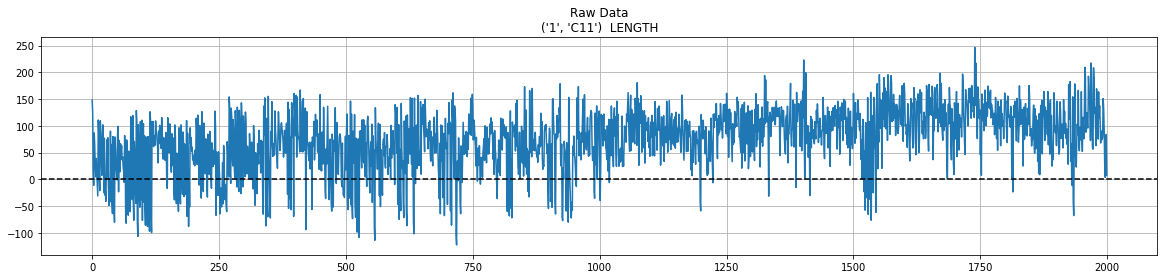

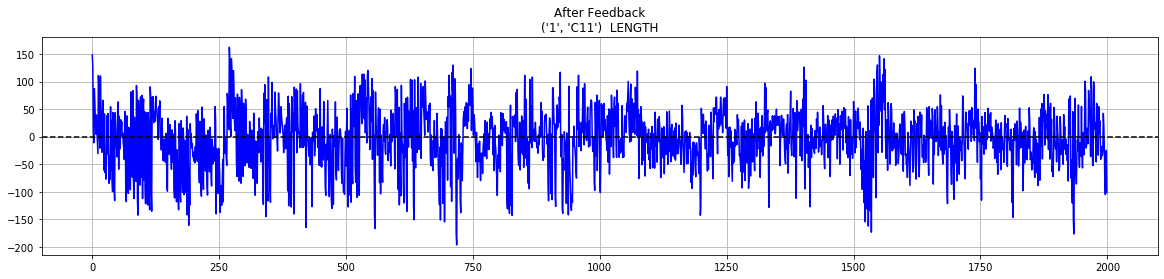

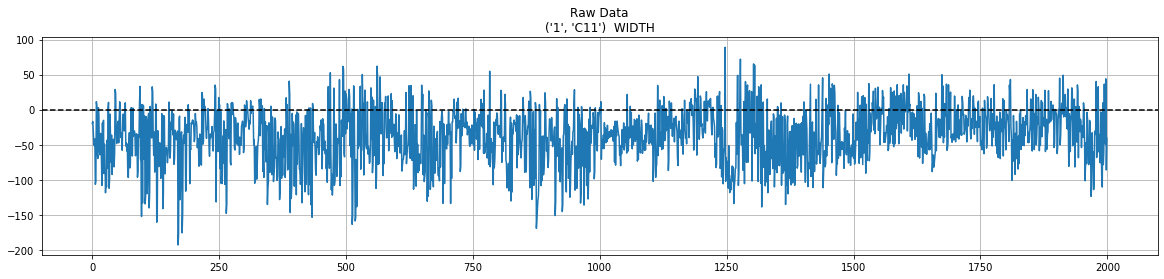

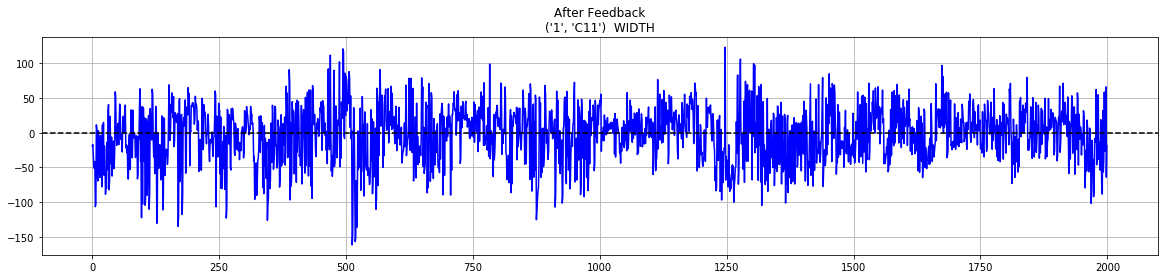

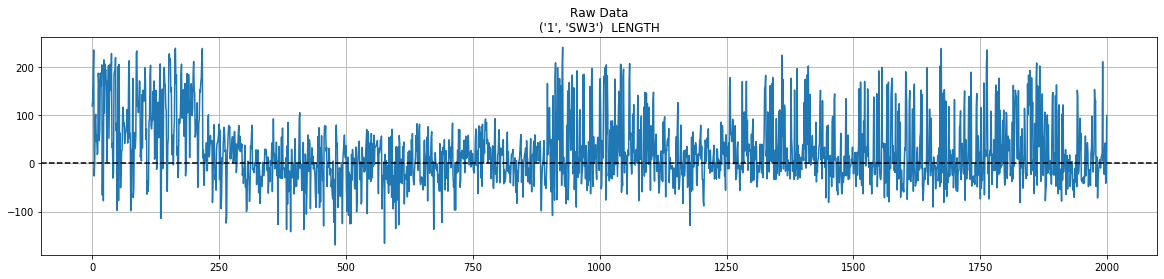

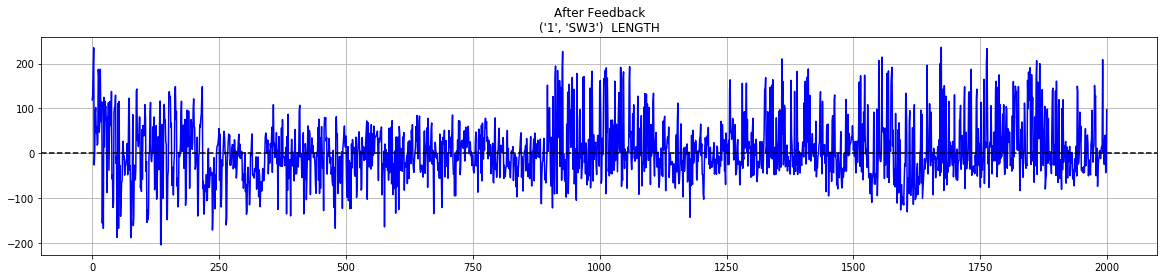

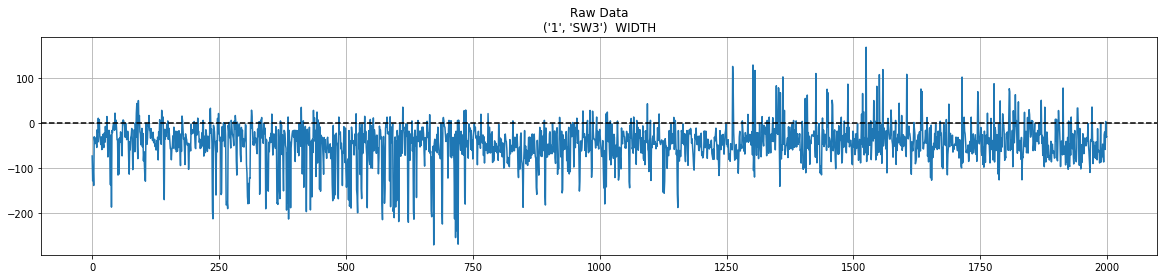

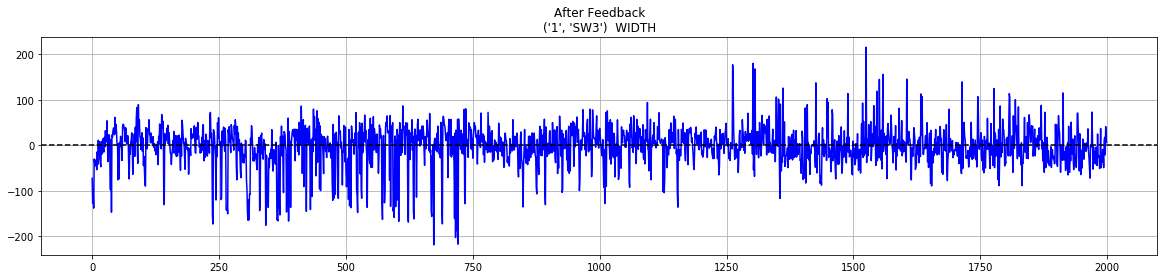

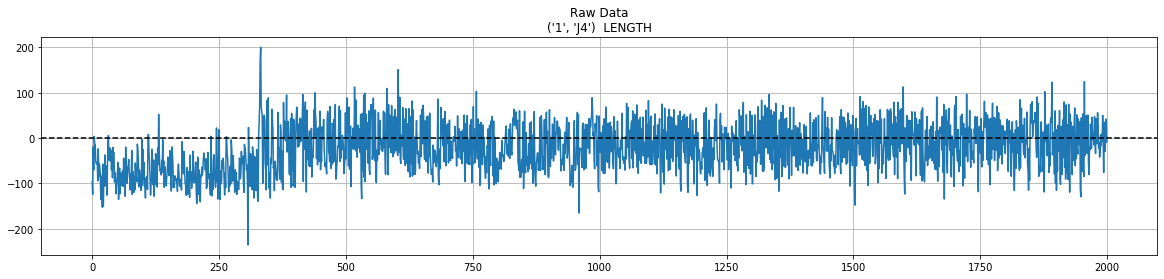

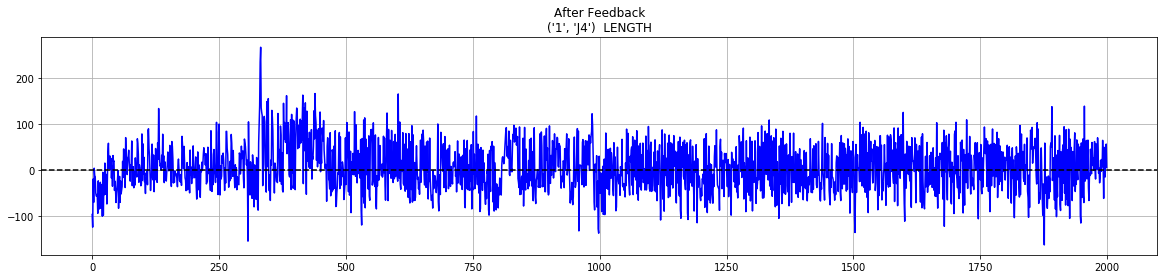

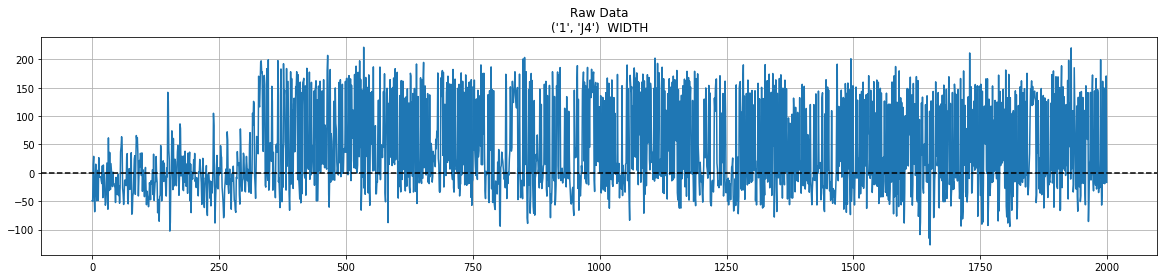

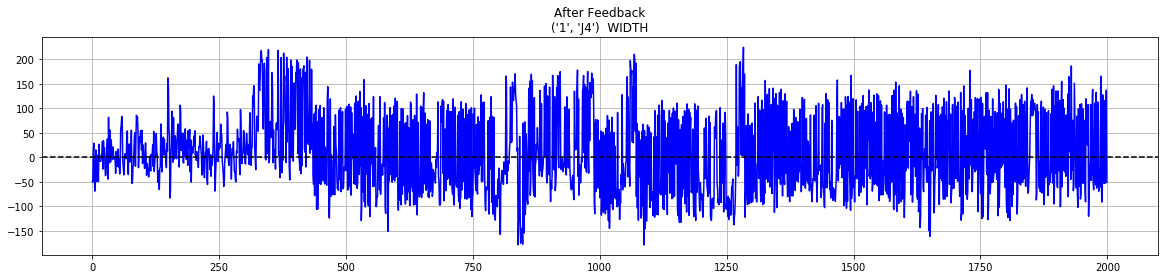

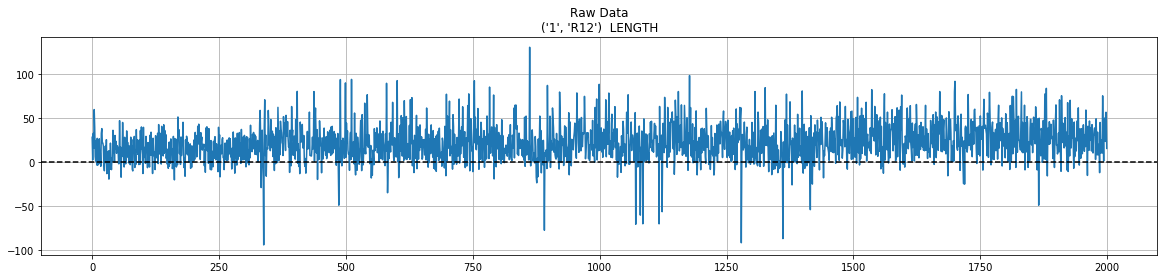

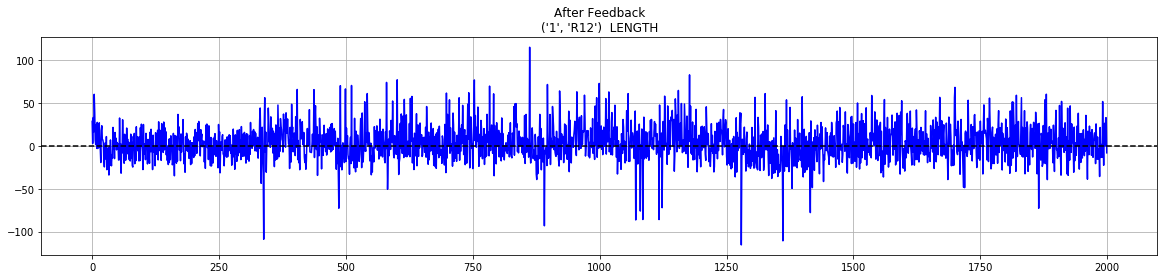

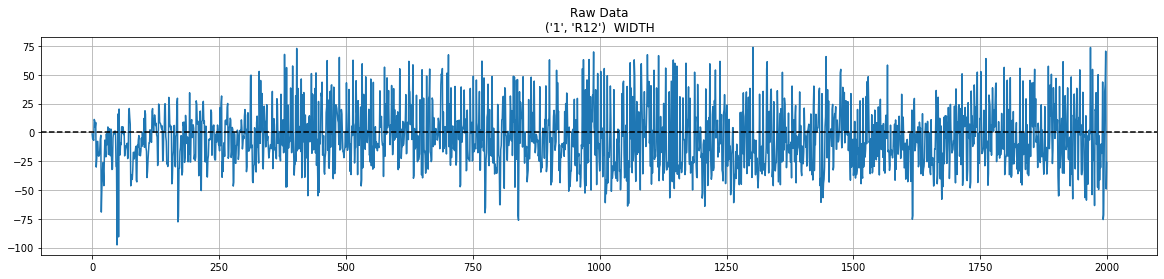

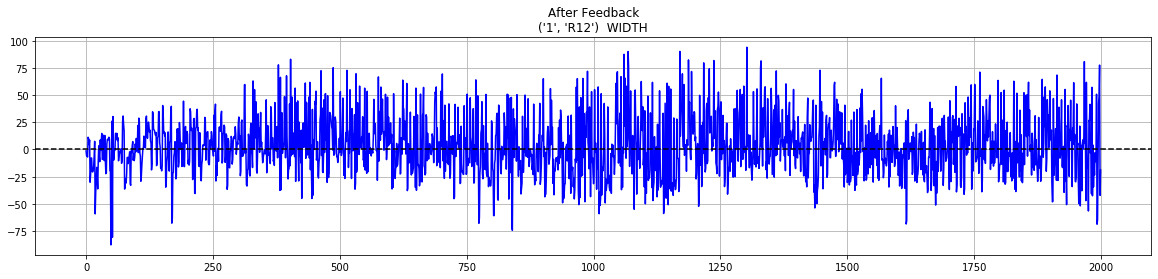

In [103]:
if __name__ == '__main__':
    import os
    import json
    import copy
    
    Data_temp = pd.read_csv("C:/Users/T5402/Downloads/n1_test_500k.txt", sep=',')

    json_directory_path = 'C:/Users/T5402/Desktop/merge_samples'
    json_file_list = os.listdir(json_directory_path)
    
    f = open(json_directory_path+'/'+json_file_list[0],'r')
    json_data = dict(json.load(f))
    
    TimeSequence = 2000
    
    MFB = MounterFeedback(MaxOpNum=1)
    MFB.Ready(json_data)
    mounter = MounterSimulator(json_data)
    
    raw_monitor = Monitor(json_data)
    feedback_monitor = Monitor(json_data)
    
    DEFAULT_FEEDBACK_INFO = {'FeedbackType': 'PLACEDLOCATIONOFFSET',
                             'SeqID': '',
                             'Time': 20200225192248,
                             'MachineName': 'L509A',
                             'LaneNo': '1',
                             'Target': '1',
                             'NumList': 4,
                             'CPDLIST': [{'BLOCK_NO': '1', 'REFERENCE': 'C11',
                                          'LENGTH_CPD': -1, 'WIDTH_CPD': -1}, 
                                         {'BLOCK_NO': '1', 'REFERENCE': 'SW3',
                                          'LENGTH_CPD': -1, 'WIDTH_CPD': -1}, 
                                         {'BLOCK_NO': '1', 'REFERENCE': 'J4',
                                          'LENGTH_CPD': -1, 'WIDTH_CPD': -1}, 
                                         {'BLOCK_NO': '1', 'REFERENCE': 'R12',
                                          'LENGTH_CPD': -1, 'WIDTH_CPD': -1}],
                             
                             'OFFSETLIST': [{'BLOCK_NO': '1', 'REFERENCE': 'C11',
                                             'AdjustX': (0,None), 'AdjustY': (0,None)}, 
                                            {'BLOCK_NO': '1', 'REFERENCE': 'SW3',
                                             'AdjustX': (0,None), 'AdjustY': (0,None)}, 
                                            {'BLOCK_NO': '1', 'REFERENCE': 'J4',
                                             'AdjustX': (0,None), 'AdjustY': (0,None)}, 
                                            {'BLOCK_NO': '1', 'REFERENCE': 'R12',
                                             'AdjustX': (0,None), 'AdjustY': (0,None)}]}
    
    FEEDBACK_INFO = copy.deepcopy(DEFAULT_FEEDBACK_INFO)
    
    for i, file_name in enumerate(json_file_list[:TimeSequence]):
#         f = open(json_directory_path+'/'+file_name,'r')
        f = open(json_directory_path+'/' + str(i) + '.json','r')
        json_data = dict(json.load(f))
        raw_monitor.PutData(json_data)
        
        json_data = mounter.PLANT(FEEDBACK_INFO, json_data)
        FEEDBACK_INFO = MFB.Step(json_data)
        
        feedback_monitor.PutData(json_data)
 
    for component_info in MFB.Component_Info_List[:]:
        for AXIS in ['LENGTH','WIDTH']:
            raw_monitor.Draw(AXIS,component_info,
                             title = 'Raw Data\n'+str(component_info)+'  '+AXIS)
            feedback_monitor.Draw(AXIS,component_info,
                                  title = 'After Feedback\n'+str(component_info)+'  '+AXIS, color = 'blue')